In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
db=wrds.Connection(wrds_username='kmlnr')
#db.create_pgpass_file()


c:\Users\Kamal\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading library list...
Done


In [3]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10028,1992-06-30,-0.206897,5632.0,-1.43750,8096.000,NaN,0.002928,-0.019258,1,-0.209825,-0.022186
1,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.000,0.003030,0.006407,1,-0.208509,0.003377
2,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.750,0.002920,0.013414,1,-0.173375,0.010494
3,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.375,0.003343,-0.023699,1,0.416012,-0.027042
4,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.000,0.003806,-0.025746,1,0.043813,-0.029552


# Part 3 Betting Against Betta

## Estimating rolling betas

In [4]:
#Copying dataframe for safe measure
df3=df.copy()


In [5]:
#Drop NaNs
df3=df3.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Remove scarce data 
df3['N'] = df3.groupby(['permno'])['date'].transform('count')
df3 = df3[df3['N']>60].copy()

#Estimate Rolling Betas
cov_nm = df3.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

#reconstruct df
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
df3 = pd.merge(df3, beta_n, on=['date','permno'], how='left')

#Winsorsize
df3['beta'] = df3['beta'].clip(df3['beta'].quantile(0.05),df3['beta'].quantile(0.95))

#Show first 5 rows
df3.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,beta
0,10028,1992-05-29,-0.205479,5548.0,-1.81250,10055.750,8096.000,0.003030,0.006407,1,-0.208509,0.003377,274,NaN
1,10028,1992-04-30,-0.170455,5548.0,-2.28125,12656.375,10055.750,0.002920,0.013414,1,-0.173375,0.010494,274,NaN
2,10028,1992-03-31,0.419355,5548.0,2.75000,15257.000,12656.375,0.003343,-0.023699,1,0.416012,-0.027042,274,NaN
3,10028,1998-05-29,0.047619,4151.0,2.75000,11415.250,15257.000,0.003806,-0.025746,1,0.043813,-0.029552,274,NaN
4,10028,1998-04-30,0.050000,4151.0,2.62500,10896.375,11415.250,0.003940,0.010924,1,0.046060,0.006984,274,NaN


## PF Decile

In [6]:
#Generate Quantiles
df3=df3.dropna(subset=['beta']).copy()
df3['beta_q']=df3.groupby('date')['beta'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df3.groupby(['date','beta_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_q')['Rn'].std()



# Value-weighed pfs
df3['vw_Q']=df3['mcap']/(df3.groupby(['date','beta_q'])['mcap'].transform('sum'))
df3['ret_vw'] = df3['vw_Q']*df3['Rn']
ret_vw = df3.groupby(['date','beta_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_q')['ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_q')['ret_vw'].std()

In [11]:
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])

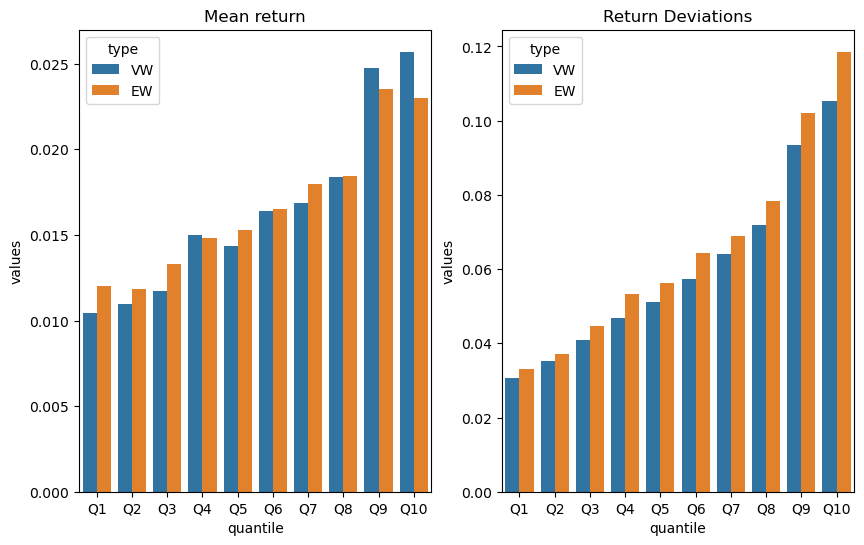

In [23]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,2,figsize=(10,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
plt.show()

##TODO SHAPR RATIO PLOTTING

## BAB PF Construction